In [2]:
# Import libraries
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import random
import copy

import math


from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


import seaborn as sns
import matplotlib.dates as mdates
#import matplotlib
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot


import warnings
warnings.filterwarnings("ignore") # In order not to show the warnings in the notebook


# 1. Data Preprocessing

### a. Importing and Analysing the Data

In [3]:
# Importing data 
Bitcoin_data = pd.read_csv('data.csv', parse_dates=['Date'], sep=',', index_col='Date')
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
Bitcoin_data.head(5)

,Open,High,Low,Adj Close,Volume,Close
Date,,,,,,
2014-09-16,465.864014,468.174011,452.421997,457.334015,21056800.0,457.334015
2014-09-17,456.859985,456.859985,413.104004,424.440002,34483200.0,424.440002
2014-09-18,424.102997,427.834992,384.532013,394.795990,37919700.0,394.795990
2014-09-19,394.673004,423.295990,389.882996,408.903992,36863600.0,408.903992
2014-09-20,408.084992,412.425995,393.181000,398.821014,26580100.0,398.821014


In [4]:
# checking for nulls
Bitcoin_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2586 entries, 2014-09-16 to 2021-10-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2586 non-null   float64
 1   High       2586 non-null   float64
 2   Low        2586 non-null   float64
 3   Adj Close  2586 non-null   float64
 4   Volume     2586 non-null   float64
 5   Close      2586 non-null   float64
dtypes: float64(6)
memory usage: 141.4 KB


In [5]:
# checking if close is not equal to adj close
Bitcoin_data[Bitcoin_data['Close']!=Bitcoin_data['Adj Close']]

,Open,High,Low,Adj Close,Volume,Close
Date,,,,,,


In [6]:
# checking the main parameters
Bitcoin_data.describe()

,Open,High,Low,Adj Close,Volume,Close
count,2586.000000,2586.000000,2586.000000,2586.000000,2.586000e+03,2586.000000
mean,9460.479761,9729.703537,9173.223236,9483.798763,1.375499e+10,9483.798763
std,13881.464139,14299.916556,13424.115329,13919.027751,1.989196e+10,13919.027751
min,176.897003,211.731003,171.509995,178.102997,5.914570e+06,178.102997
25%,577.754990,582.823242,573.438751,577.567490,7.406615e+07,577.567490
50%,5515.076172,5647.827149,5353.012940,5540.485107,4.568140e+09,5540.485107
75%,9699.704834,9908.871582,9507.834717,9700.673340,2.224211e+10,9700.673340
max,63523.753910,64863.097660,62208.964840,63503.457030,3.510000e+11,63503.457030


In [7]:
# plotting Closing Price and Volume
from plotly.subplots import make_subplots
import plotly.graph_objects as go


fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(go.Scatter(x=Bitcoin_data['Close'].index, y=Bitcoin_data['Close'].values, name='Close'), secondary_y=False)

fig.add_trace(go.Scatter(x=Bitcoin_data['Volume'].index, y=Bitcoin_data['Volume'].values, name='Volume'), secondary_y=True)

# Add figure title
fig.update_layout(title_text="BTC: {}, {}".format('Close', 'Volume'))

# Set x-axis title
fig.update_xaxes(title_text='<b>Date</b>')

# Set y-axes titles
fig.update_yaxes(title_text='<b>Close</b>', secondary_y=False)
fig.update_yaxes(title_text='<b>Volume</b>', secondary_y=True)

# Adding slider
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

### We can observe a spike in volume around end of Feb2021. Let's take a look.

In [8]:
# looking at Feb21 datapoints
Bitcoin_data[(Bitcoin_data.index>'2021-02-15') & (Bitcoin_data.index<'2021-03-01')].style.bar(subset=['Volume'], color='Yellow')

,Open,High,Low,Adj Close,Volume,Close
Date,,,,,,
2021-02-16 00:00:00,47944.457030,50341.101560,47201.304690,49199.871090,77049582886.000000,49199.871090
2021-02-17 00:00:00,49207.277340,52533.914060,49072.378910,52149.007810,80820545404.000000,52149.007810
2021-02-18 00:00:00,52140.972660,52474.105470,51015.765630,51679.796880,52054723579.000000,51679.796880
2021-02-19 00:00:00,51675.980470,56113.652340,50937.277340,55888.132810,63495496918.000000,55888.132810
2021-02-20 00:00:00,55887.335940,57505.226560,54626.558590,56099.519530,68145460026.000000,56099.519530
2021-02-21 00:00:00,56068.566410,58330.570310,55672.609380,57539.945310,51897585191.000000,57539.945310
2021-02-22 00:00:00,57532.738280,57533.390630,48967.566410,54207.320310,92052420332.000000,54207.320310
2021-02-23 00:00:00,54204.929690,54204.929690,45290.589840,48824.425780,106000000000.000000,48824.425780
2021-02-24 00:00:00,48835.085940,51290.136720,47213.500000,49705.332030,63695521388.000000,49705.332030


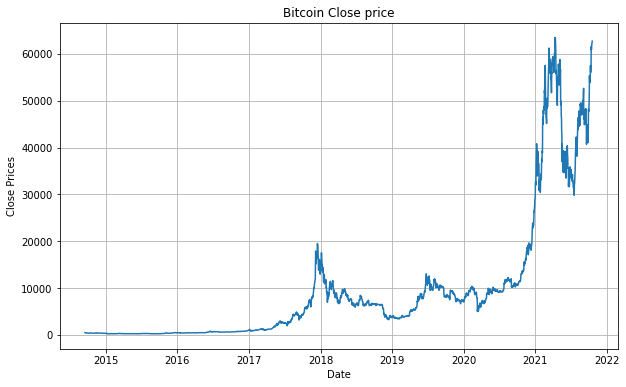

In [9]:
# Plot closing prices
df_close = Bitcoin_data['Close']

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(df_close)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.title('Bitcoin Close price');

### b. Checking Stationarity

In [10]:
  def test_stationarity(timeseries):
    '''
    Input: timeseries (dataframe): timeseries for which we want to study the stationarity
    '''
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',\
                                             '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

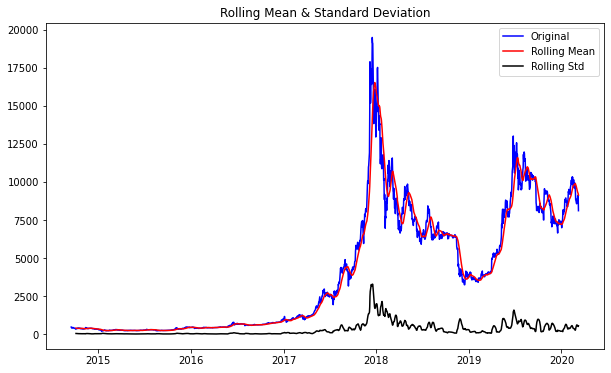

Results of Dickey-Fuller Test:
Test Statistic                   -1.744147
p-value                           0.408522
#Lags Used                       21.000000
Number of Observations Used    1978.000000
Critical Value (1%)              -3.433660
Critical Value (5%)              -2.863002
Critical Value (10%)             -2.567548
dtype: float64


In [11]:
plt.figure(figsize = (10,6))
test_stationarity(df_close.head(2000))

<Figure size 432x288 with 0 Axes>

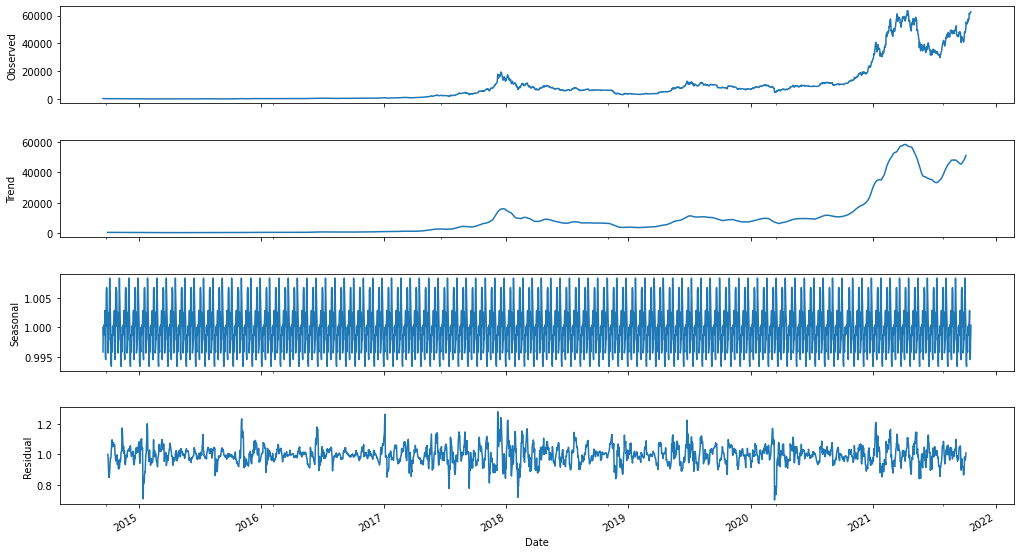

In [12]:
#To plot the trend and the seasonality
# We set the period to 28 as we have in average 7*4 = 28 days in a month
# The result below is just to have a first visualization of trend andseasonality. Here we take a monthly average but to forecast a bitcoin 
# price, it is more difficult than that to choose the right number of days to average on
result = seasonal_decompose(df_close, model='multiplicative', freq=28)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9);

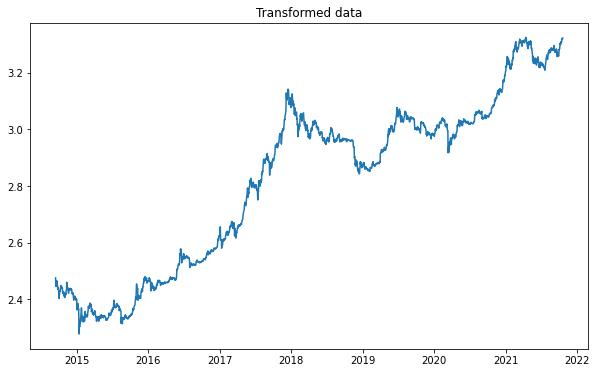

In [13]:
df_close_log = df_close.apply(np.log)
df_close_tf = df_close_log.apply(np.sqrt)

plt.figure(figsize = (10,6))
plt.plot(df_close_tf)
plt.title('Transformed data');

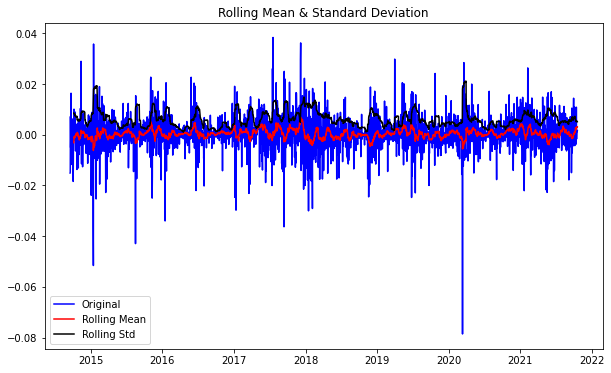

Results of Dickey-Fuller Test:
Test Statistic                -1.548004e+01
p-value                        2.563303e-28
#Lags Used                     9.000000e+00
Number of Observations Used    2.575000e+03
Critical Value (1%)           -3.432892e+00
Critical Value (5%)           -2.862663e+00
Critical Value (10%)          -2.567368e+00
dtype: float64


In [14]:
df_close_shift = df_close_tf - df_close_tf.shift()

df_close_shift.dropna(inplace=True)
plt.figure(figsize = (10,6))
test_stationarity(df_close_shift)

# Regression

In [78]:
# S_3 is the moving average of 3 previous days
# S_9 is the moving average of 9 previous days
reg_data = copy.deepcopy(Bitcoin_data)
reg_data['S_3'] = reg_data['Close'].shift(1).rolling(window=3).mean() 
reg_data['S_9']= reg_data['Close'].shift(1).rolling(window=9).mean() 


# We define X_i as the ith previous close price. For instance, X_1 is 1st previous price which is yesterday's price.
for i in range(1,11):
    reg_data["X_{0}".format(i)] = reg_data['Close'].shift(i)
    
# We define R_i as the ith previous return. For instance, R_1 is 1st previous return which is yesterday's return.
# Return(t) = P(t)/P(t-1)
for i in range(1,11):
    reg_data["R_{0}".format(i)] = (reg_data['Close'].shift(i))/(reg_data['Close'].shift(i+1))
    
# We define V_i as the ith previous volume. For instance, V_1 is 1st previous volume which is yesterday's volume of interactions.
for i in range(1,11):
    reg_data["V_{0}".format(i)] = reg_data['Volume'].shift(i)

reg_data= reg_data.dropna() 

required_features = ['S_3','S_9','X_1','X_2','X_3','X_4','X_5','X_6','X_7','X_8','X_9','X_10']
# We use two moving averages plus the 10 previous close prices as inputs of our model.

required_features_wo = ['X_1','X_2','X_3','X_4','X_5','X_6','X_7','X_8','X_9','X_10']
# We use only the 10 previous close prices as inputs of our model.

required_features_r = ['R_1','R_2','R_3','R_4','R_5','R_6','R_7','R_8','R_9','R_10']
# We use only the 10 previous returns of price as inputs of our model.

required_features_v = ['S_3','S_9','X_1','X_2','X_3','X_4','X_5','X_6','X_7','X_8','X_9','X_10','V_1','V_2','V_3','V_4','V_5','V_6','V_7','V_8','V_9','V_10']
# We use two moving averages plus the 10 previous close prices plus 10 previous volume of interactions as inputs of our model.

output_label = 'Close'
# We use Close price as the output of our models based on absolute values.

# We define r_1 as the return of today's price
reg_data["r_1"] = reg_data["Close"]/reg_data["X_1"] 

output_label_r = 'r_1'
# We use Close price as the output of our models based on relative changes of prices.


# Linear Model with Absolute Values
#print("Linear Model with Absolute Values")
required_features = []
for i in range(1,11):
    required_features.append("X_{0}".format(i))
    X = reg_data[required_features]
    y = reg_data[output_label]
    t=.8
    t = int(t*len(reg_data)) 
    X_train = X[:t] 
    y_train = y[:t]   
    X_test = X[t:] 
    y_test = y[t:]
    model = LinearRegression().fit(X_train, y_train)
    #print("MAPE{0} = ".format(i),mean_absolute_percentage_error(y_test, model.predict(X_test))*100,"%")
    #print("MAE{0} = ".format(i),mean_absolute_error(y_test, model.predict(X_test)))
    #print("RMSE{0} = ".format(i),np.sqrt(mean_squared_error(y_test, model.predict(X_test))))
    
    
# Linear Model with Absolute Values and Moving Average Values
#print("\n")
#print("Linear Model with Absolute Values and Moving Average Values")
required_features = ['S_3','S_9']
for i in range(1,11):
    required_features.append("X_{0}".format(i))
    X = reg_data[required_features]
    y = reg_data[output_label]
    t=.8
    t = int(t*len(reg_data)) 
    X_train = X[:t] 
    y_train = y[:t]   
    X_test = X[t:] 
    y_test = y[t:]
    model = LinearRegression().fit(X_train, y_train)
    #print("MAPE{0} = ".format(i),mean_absolute_percentage_error(y_test, model.predict(X_test))*100,"%")
    #print("MAE{0} = ".format(i),mean_absolute_error(y_test, model.predict(X_test)))
    #print("RMSE{0} = ".format(i),np.sqrt(mean_squared_error(y_test, model.predict(X_test))))


# Linear Model with Absolute Values and Volume of Transactions
#print("\n")
#print("Linear Model with Absolute Values and Volume of Transactions")
required_features = ['S_3','S_9','X_1','X_2','X_3','X_4','X_5','X_6','X_7','X_8','X_9','X_10']
for i in range(1,11):
    required_features.append("V_{0}".format(i))
    X = reg_data[required_features]
    y = reg_data[output_label]
    t=.8
    t = int(t*len(reg_data)) 
    X_train = X[:t] 
    y_train = y[:t]   
    X_test = X[t:] 
    y_test = y[t:]
    model = LinearRegression().fit(X_train, y_train)
    #print("MAPE{0} = ".format(i),mean_absolute_percentage_error(y_test, model.predict(X_test))*100,"%")
    #print("MAE{0} = ".format(i),mean_absolute_error(y_test, model.predict(X_test)))
    #print("RMSE{0} = ".format(i),np.sqrt(mean_squared_error(y_test, model.predict(X_test))))


    
# Linear Model with Relative Values    
#print("\n")
#print("Linear Model with Relative Values")
required_features = []
y_r = reg_data[output_label_r]
for i in range(1,11):
    required_features.append("R_{0}".format(i))
    X_r = reg_data[required_features]
    t=.8
    t = int(t*len(reg_data)) 
    X_train_r = X_r[:t] 
    y_train_r = y_r[:t]   
    X_test_r = X_r[t:] 
    y_test_r = y_r[t:]
    y_test = y[t:]
    model_r = LinearRegression().fit(X_train_r, y_train_r)
    y_predict = np.multiply(model_r.predict(X_test_r),X_test['X_1'])
    #print("MAPE{0} = ".format(i),mean_absolute_percentage_error(y_test_r, model_r.predict(X_test_r))*100,"%")
    #print("MAE{0} = ".format(i),mean_absolute_error(y_test, y_predict))
    #print("RMSE{0} = ".format(i),np.sqrt(mean_squared_error(y_test, y_predict)))



# Polynomial Model with Absolute Values
#print("\n")
#print("Polynomial Model with Absolute Values")
required_features = []
for i in range(1,11):
    required_features.append("X_{0}".format(i))
    X = reg_data[required_features]
    y = reg_data[output_label]
    polynomial_features= PolynomialFeatures(degree=2)
    X_poly = polynomial_features.fit_transform(X)

    t=.8
    t = int(t*len(reg_data)) 
    # Train dataset 
    X_train_poly = X_poly[:t] 
    y_train = y[:t]  
    # Test dataset 
    X_test_poly = X_poly[t:] 
    y_test = y[t:]

    model_poly = LinearRegression()
    model_poly.fit(X_train_poly, y_train)

    y_poly_pred = model_poly.predict(X_train_poly)
    #print(model_poly.score(X_test_poly, y_test))
    #print("MAPE{0} = ".format(i),mean_absolute_percentage_error(y_test, model_poly.predict(X_test_poly))*100,"%")
    #print("MAE{0} = ".format(i),mean_absolute_error(y_test, model_poly.predict(X_test_poly)))
    #print("RMSE{0} = ".format(i),np.sqrt(mean_squared_error(y_test, model_poly.predict(X_test_poly))))

required_features = ['R_1','R_2','R_3','R_4','R_5','R_6']
X_r = reg_data[required_features]
t=.8
t = int(t*len(reg_data)) 
X_test = X[t:] 
X_train_r = X_r[:t] 
y_train_r = y_r[:t]   
X_test_r = X_r[t:] 
y_test_r = y_r[t:]
y_test = y[t:]
model_r = LinearRegression().fit(X_train_r, y_train_r)
pred_data_regr = np.multiply(model_r.predict(X_test_r),X_test['X_1'])
print("MAE{0} = ",mean_absolute_error(y_test, pred_data_regr))
print("RMSE{0} = ",np.sqrt(mean_squared_error(y_test, pred_data_regr)))


MAE{0} =  925.9990073486066
RMSE{0} =  1482.3790347129345


# Arima

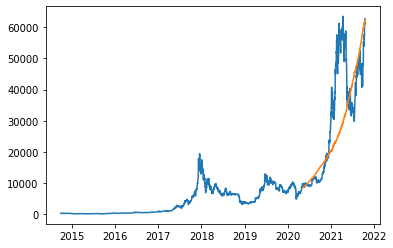

In [80]:
# We take close prices as our output
df= reg_data["Close"]
df_log = np.log(df)
for i in [3]:
    # We take first 80% of our data to be training data and the 20% of last data to be the test data
    model = ARIMA(df_log[2051:], order=(i,1,2))
    results = model.fit(disp=1)
    predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
    predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
    predictions_ARIMA_log = pd.Series(df_log[2051:].iloc[0], index=df_log[2051:].index)
    predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
    predictions_ARIMA = np.exp(predictions_ARIMA_log)
    plt.figure()
    plt.plot(df)
    plt.plot(predictions_ARIMA)
    y_predict = predictions_ARIMA
    y_test = df[2051:]

In [108]:
predictions_ARIMA

Date
2020-05-10     8601.795898
2020-05-11     8634.420424
2020-05-12     8657.589442
2020-05-13     8665.398100
2020-05-14     8671.128120
                  ...     
2021-10-14    61618.863698
2021-10-15    61775.487915
2021-10-16    61624.519496
2021-10-17    62172.356388
2021-10-19    62412.448577
Length: 526, dtype: float64

In [70]:
y_test.shape

(518,)

# Prophet

In [113]:
# Preprocessing:Creating a two-column dataset to use in time series analysis
df = Bitcoin_data
prophet_data = df[['Date', 'Close']]
prophet_data = prophet_data.set_index('Date')
scaled_data = df_close_shift
#To convert the frequency of the dataframe to weekly and then return the values of the axis.(periods of 7 days)
weekly_prophet = scaled_data.resample('W').mean()
#Reset the index of the DataFrame, and remove missing values with dropna() 
week_seasonality = weekly_prophet.reset_index().dropna()

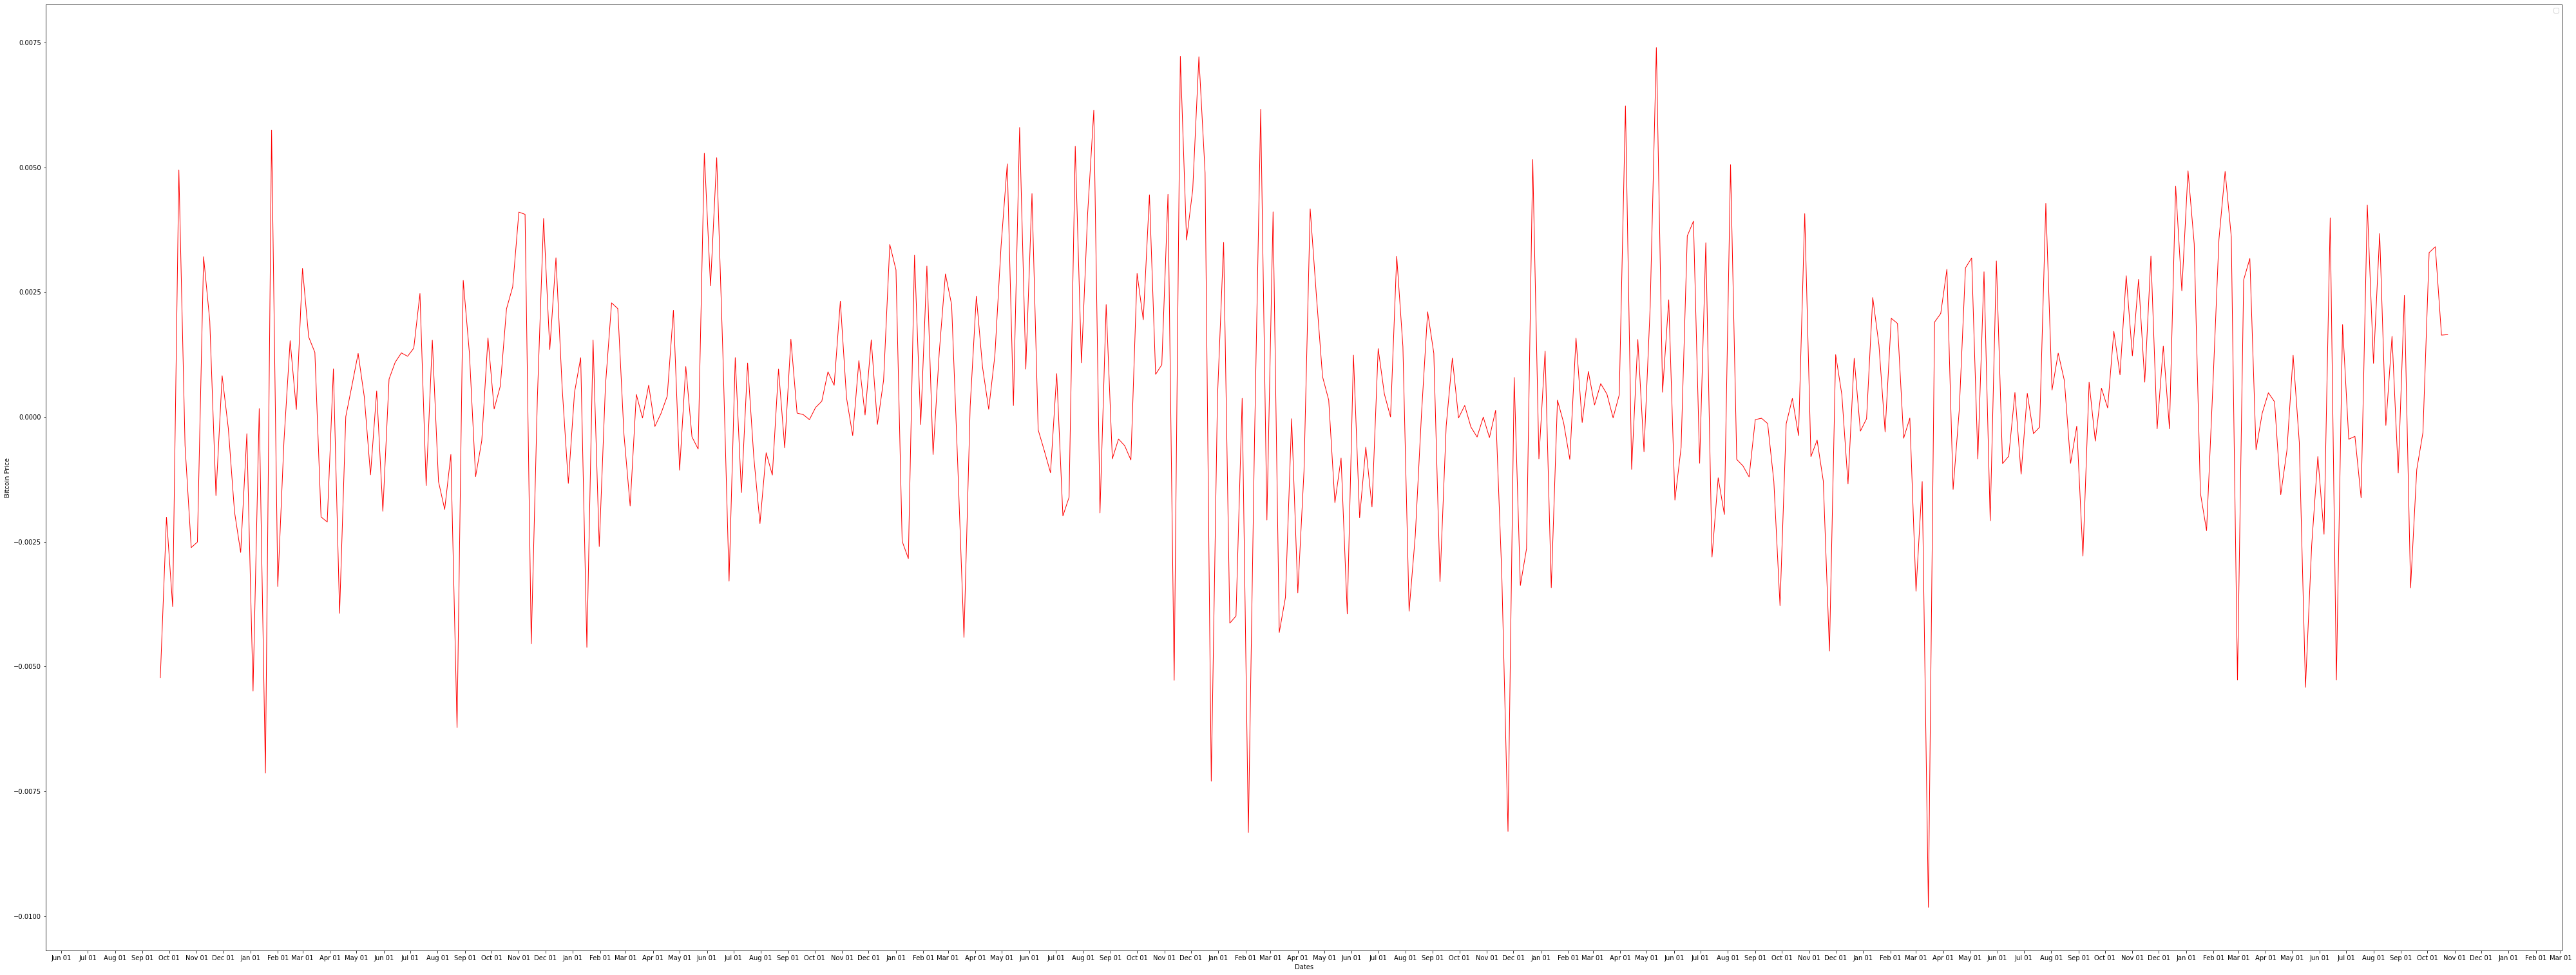

In [114]:
# Plotting the weekly average prices by month
fig = plt.figure(figsize = (70, 27))
ax = plt.axes()
#set ticks every month to  show the month value on the x axis
ax.xaxis.set_major_locator(mdates.MonthLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.plot(week_seasonality['Date'],week_seasonality['Close'],color='r', linewidth=1)
plt.xlabel("Dates")
plt.ylabel("Bitcoin Price")
plt.legend()
plt.show()

In [115]:
#Preprocessing :The input for the prophet is the two columns of ds which is the formated version of the "Date" and "y" as the target
week_seasonality.columns = ['ds', 'y']
#Modeling and analysis based on yearly seasonlity
prophet_model=Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=False, changepoint_range=1) 
#interval_width sets the uncertainty interval to produce a confidence interval around the forecast
prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)
#fitting the model
prophet_model.fit(week_seasonality)
#To predict the average Close prices of next month
future_month = prophet_model.make_future_dataframe(freq='W', periods=4)  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [116]:
#predict the future month
forecast_future_month = prophet_model.predict(future_month)


In [117]:
daily_mean = scaled_data.resample('D').mean()
#Reset the index of the DataFrame, and remove missing values with dropna() 
daily_prophet = daily_mean.reset_index().dropna()
daily_prophet.sort_values(by=['Date'])
daily_prophet.columns = ['ds', 'y']
prophet_model=Prophet(interval_width=0.95, daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True,changepoint_range=1) 
#interval_width sets the uncertainty interval to produce a confidence interval around the forecast
prophet_model.add_seasonality(name='daily_seasonailty', period=1, fourier_order=5, prior_scale=0.02)
prophet_model.fit(daily_prophet)
#periods will generate a range of evenly spaced dates from start to end inclusively number of elements in the resulting DatetimeIndex
future_days = prophet_model.make_future_dataframe(freq='D', periods=70) 

In [120]:
next_day = prophet_model.predict(future_days[-505:])
pred_array = next_day['yhat'].values
prophet_test_days = len(next_day)
print(prophet_test_days)
prophet_test_original = df_close.iloc[-prophet_test_days:]
pred_size = len(next_day)
pred_array = pred_array.reshape(pred_size, 1)
pred_data = pd.DataFrame(pred_array[:,0], prophet_test_original.index,columns=['Close'])
pred_data['Close'] = pred_data['Close'] + df_close_tf.shift().values[-prophet_test_days:] 
pred_data = pred_data.apply(np.square)
pred_data = pred_data.apply(np.exp)
pred_data_prophet = pred_data

505


In [119]:
    true_data = Bitcoin_data['Close'].values
    true_data = true_data[-prophet_test_days:].reshape(prophet_test_days, 1)
    test_mae = mean_absolute_error(true_data, pred_data)
    test_mse = mean_squared_error(true_data, pred_data, squared=True)
    test_rmse = mean_squared_error(true_data, pred_data, squared=False)
    test_r2 = r2_score(true_data, pred_data)

    print("\n****---- Test Metrics ----****")
    print(" MAE : {:.4f}".format(np.average(test_mae.item())))
    print("RMSE : {:.4f}".format(np.average(test_rmse.item())))



****---- Test Metrics ----****
 MAE : 952.7016
RMSE : 1498.3433


# CNN

In [89]:

# Scaling
bd = df_close_shift.values
cnn_dataset = bd.reshape(len(bd), 1)


In [90]:
class CNN(torch.nn.Module):
    """Convolutional Neural Networks"""
    def __init__(self, input_size, hidden_dim, output_size):
        super(CNN, self).__init__()

        self.main = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=input_size, out_channels=hidden_dim, kernel_size=1),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(hidden_dim, 10),
            torch.nn.Linear(10, output_size)
        )

    def forward(self, x):
        out = self.main(x)
        return out

In [91]:
def split_sequence(sequence, n_steps):
    """
    Given the data set and n_steps as the window size
    returns two Numpy array X and y separetd based on the n_step
    """
    X, y = list(), list()

    for i in range(len(sequence)):
        end_ix = i + n_steps

        if end_ix > len(sequence)-1:
            break

        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]

        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

In [92]:
def data_loader(x, y, train_split, test_split, batch_size):
    """Prepare data by applying sliding windows and return data loader"""

    # Split to Train, Validation and Test Set #
    train_seq, test_seq, train_label, test_label = train_test_split(x, y, train_size=train_split, shuffle=False)
    val_seq, test_seq, val_label, test_label = train_test_split(test_seq, test_label, train_size=test_split, shuffle=False)
    
    # Convert to Tensor #
    train_set = TensorDataset(torch.from_numpy(train_seq.astype(np.float32)), torch.from_numpy(train_label.astype(np.float32)))
    val_set = TensorDataset(torch.from_numpy(val_seq.astype(np.float32)), torch.from_numpy(val_label.astype(np.float32)))
    test_set = TensorDataset(torch.from_numpy(test_seq.astype(np.float32)), torch.from_numpy(test_label.astype(np.float32)))

    # Data Loader #
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    print('Proportion of train_set : {:.2f}%'.format(len(train_set)/len(Bitcoin_data)))
    print('Proportion of valid_set : {:.2f}%'.format(len(val_set)/len(Bitcoin_data)))
    print('Proportion of test_set : {:.2f}%'.format(len(test_set)/len(Bitcoin_data)))

    return train_loader, val_loader, test_loader

In [93]:
cnn_n_steps = 60
batch_size = 128
X, y = split_sequence(cnn_dataset, cnn_n_steps)
train_loader, val_loader, test_loader = data_loader(X, y, 0.6, 0.5, batch_size)

train_losses, val_losses = list(), list()
val_maes, val_mses, val_rmses, val_r2s = list(), list(), list(), list()
test_maes, test_mses, test_rmses, test_r2s = list(), list(), list(), list()
pred_tests, labels = list(), list()

Proportion of train_set : 0.59%
Proportion of valid_set : 0.20%
Proportion of test_set : 0.20%


In [94]:
epochs = 100
cnn_model = CNN(cnn_n_steps, batch_size, 1)
criterion = torch.nn.MSELoss()

# Optimizer 
optim = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)

In [96]:
#CNNTrain
for epoch in range(epochs):
    for i, (data, label) in enumerate(train_loader):
            # Forward Data
            pred = cnn_model(data)

            # Calculate Loss
            train_loss = criterion(pred, label)

            # Initialize Optimizer, Back Propagation and Update
            optim.zero_grad()
            train_loss.backward()
            optim.step()

            # Add item to Lists
            train_losses.append(train_loss.item())

            # Print Statistics
    if (epoch+1) % 10 == 0:
            print("Epoch [{}/{}]".format(epoch+1, epochs))
            print("Train Loss {:.4f}".format(np.average(train_losses)))

    # Validation
    with torch.no_grad():
        for i, (data, label) in enumerate(val_loader):
            # Forward Data
            pred_val = cnn_model(data)
            # Calculate Loss
            val_loss = criterion(pred_val, label)

            # Calculate Metrics
            val_mae = mean_absolute_error(label, pred_val)
            val_mse = mean_squared_error(label, pred_val, squared=True)
            val_rmse = mean_squared_error(label, pred_val, squared=False)
            val_r2 = r2_score(label, pred_val)

            # Add item to Lists
            val_losses.append(val_loss.item())
            val_maes.append(val_mae.item())
            val_mses.append(val_mse.item())
            val_rmses.append(val_rmse.item())
            val_r2s.append(val_r2.item())
                
            if (epoch+1) % 10 == 0:
                # Print loss for each 10 epoch
                print("Val Loss {:.4f}".format(np.average(val_losses)))


Epoch [10/100]
Train Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Epoch [20/100]
Train Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Epoch [30/100]
Train Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Epoch [40/100]
Train Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Epoch [50/100]
Train Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Epoch [60/100]
Train Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Epoch [70/100]
Train Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Epoch [80/100]
Train Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Epoch [90/100]
Train Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Epoch [100/100]
Train Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001
Val Loss 0.0001


In [97]:
#CNN Test
with torch.no_grad():
    for i, (data, label) in enumerate(test_loader):
        pred_test = cnn_model(data)
        pred_tests += pred_test.tolist()
        labels += label.tolist()

In [99]:
    test_days = len(pred_tests)
    test_original = df_close.iloc[-test_days:]
    pred_array = np.array(pred_tests)
    pred_data = pd.DataFrame(pred_array[:,0], test_original.index,columns=['Close'])
    pred_data['Close'] = pred_data['Close'] + df_close_tf.shift().values[-test_days:] 
    pred_data = pred_data.apply(np.square)
    pred_data = pred_data.apply(np.exp)
    
    label_array = np.array(labels)
    true_data = pd.DataFrame(label_array[:,0], test_original.index,columns=['Close'])
    true_data['Close'] = true_data['Close'] + df_close_tf.shift().values[-test_days:] 
    true_data = true_data.apply(np.square)
    true_data = true_data.apply(np.exp)

In [100]:
    test_mae = mean_absolute_error(true_data, pred_data)
    test_mse = mean_squared_error(true_data, pred_data, squared=True)
    test_rmse = mean_squared_error(true_data, pred_data, squared=False)
    test_r2 = r2_score(true_data, pred_data)

    # Add item to Lists
    test_maes.append(test_mae.item())
    test_mses.append(test_mse.item())
    test_rmses.append(test_rmse.item())
    test_r2s.append(test_r2.item())
        
    # Print Statistics
    print("\n****---- Test Metrics ----****")
    print(" MAE : {:.4f}".format(np.average(test_maes)))
    print("RMSE : {:.4f}".format(np.average(test_rmses)))


****---- Test Metrics ----****
 MAE : 1223.7056
RMSE : 1796.8786


In [103]:
pred_data_CNN = pred_data

In [101]:
startDate = len(pred_tests)
totalDates = len(Bitcoin_data)
# Getting the dates for the test set partition

dataset_dates = Bitcoin_data.index[totalDates-startDate:]
#for i in range(startDate):
#    print(dataset_dates[i].date(),"    ",(pred_data.values[i])[0])

# LSTM

In [38]:
def preprocess_lstm(sequence, n_steps,n_features):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix >= len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
        
    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return X, y

In [39]:
# choose the number of days on which to base our predictions 
nb_days = 90

n_features = 1

X, y = preprocess_lstm(df_close_shift.to_numpy(), nb_days, n_features)

In [40]:
#Split the data set between the training set and the test set
train_days = int(len(y) * 0.8)

test_days = len(y) - train_days 

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

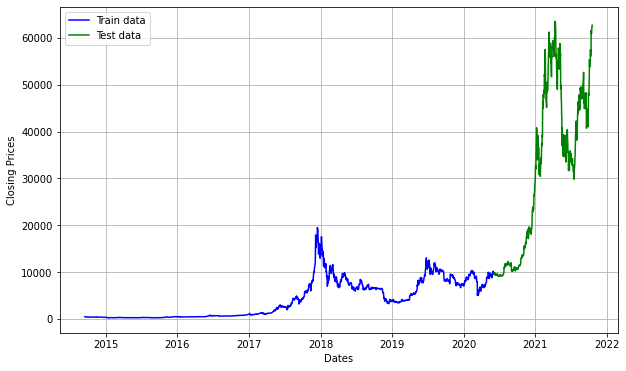

In [41]:
train_original = df_close.iloc[:-test_days]
test_original = df_close.iloc[-test_days:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.legend();

In [42]:
def vanilla_LSTM():
    model = Sequential()
    model.add(LSTM(units=100,input_shape=(nb_days, n_features),return_sequences=True)) 
    model.add(Dropout(0.2))

    model.add(LSTM(units=100,return_sequences=True)) 
    model.add(Dropout(0.2))

    model.add(LSTM(units=100,return_sequences=True)) 
    model.add(Dropout(0.2))

    model.add(LSTM(units=90, activation = 'relu', return_sequences=True)) 
    model.add(Dropout(0.2))
    model.add(LSTM(units = 90, activation = 'relu'))
    model.add(Dropout(0.2))

    model.add(Dense(1))
    return model

In [49]:
model = vanilla_LSTM()
model.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, 
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 90, 100)           40800     
                                                                 
 dropout_5 (Dropout)         (None, 90, 100)           0         
                                                                 
 lstm_6 (LSTM)               (None, 90, 100)           80400     
                                                                 
 dropout_6 (Dropout)         (None, 90, 100)           0         
                                                                 
 lstm_7 (LSTM)               (None, 90, 100)           80400     
                                                                 
 dropout_7 (Dropout)         (None, 90, 100)           0         
                                                                 
 lstm_8 (LSTM)               (None, 90, 90)           

In [50]:
# patience for the early stopping (number of epochs)
patience = 25

# Adding early stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

model.fit(X_train, y_train, epochs=100, batch_size = 32, validation_split=0.2, callbacks=[early_stop])

Epoch 1/100
50/50 [==============================] - 32s 459ms/step - loss: 5.4569e-05 - mean_absolute_error: 0.0049 - val_loss: 5.7104e-05 - val_mean_absolute_error: 0.0047
Epoch 2/100
50/50 [==============================] - 21s 414ms/step - loss: 5.1152e-05 - mean_absolute_error: 0.0046 - val_loss: 5.8338e-05 - val_mean_absolute_error: 0.0049
Epoch 3/100
50/50 [==============================] - 21s 419ms/step - loss: 5.1843e-05 - mean_absolute_error: 0.0047 - val_loss: 5.7268e-05 - val_mean_absolute_error: 0.0048
Epoch 4/100
50/50 [==============================] - 21s 425ms/step - loss: 5.0896e-05 - mean_absolute_error: 0.0046 - val_loss: 5.6340e-05 - val_mean_absolute_error: 0.0046
Epoch 5/100
50/50 [==============================] - 21s 427ms/step - loss: 5.1494e-05 - mean_absolute_error: 0.0047 - val_loss: 5.6363e-05 - val_mean_absolute_error: 0.0046
Epoch 6/100
50/50 [==============================] - 21s 423ms/step - loss: 5.1364e-05 - mean_absolute_error: 0.0046 - val_loss: 5

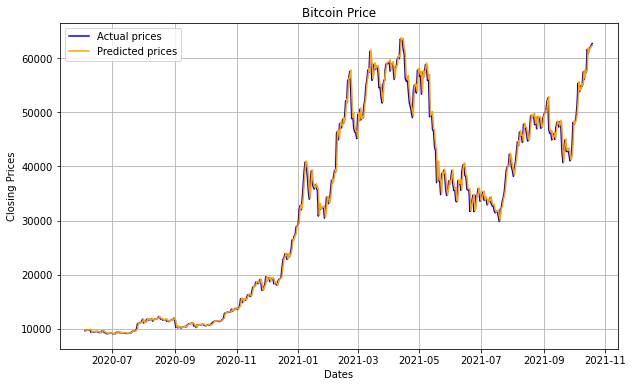

In [53]:
# Prediction
y_pred = model.predict(X_test)

# We create a dataframe from y_pred to have date-time indexes.
pred_data_LSTM = pd.DataFrame(y_pred[:,0], test_original.index,columns=['Close'])

# Apply inverse transformation from 1.d

# Add the differenciation term
pred_data_LSTM['Close'] = pred_data_LSTM['Close'] + df_close_tf.shift().values[-test_days:] 

# Take the square, and the exponent
pred_data_LSTM = pred_data_LSTM.apply(np.square)
pred_data_LSTM = pred_data_LSTM.apply(np.exp)


# Plot actual prices vs predicted prices 
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original,'b',label='Actual prices')
plt.plot(pred_data_LSTM, 'orange',label='Predicted prices')
plt.title('Bitcoin Price')

plt.legend();

In [54]:
print('LSTM MAE:',mean_absolute_error(test_original, pred_data_LSTM))
print('RMSE:')
print('LSTM RMSE:',math.sqrt(mean_squared_error(test_original, pred_data_LSTM)))

LSTM MAE: 954.356294841535
RMSE:
LSTM RMSE: 1508.8165134900614
r2:
LSTM r2: 0.9926230687678147


# Let's Make Money

In [55]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

In [56]:
# Building Prediction Matrix from the outputs of LSTM
pred_data = pred_data_LSTM
pred_data['Actual'] = test_original
pred_data = pred_data.rename(columns = {'Close': 'Predictions'})
pred_data['Sell'] = 0
pred_data['Buy'] = 0

for i in range(len(pred_data)-1):
    if (pred_data['Predictions'][i+1] - pred_data['Predictions'][i])*100/pred_data['Predictions'][i] > 5:
        pred_data['Buy'][i] = 1
    if (pred_data['Predictions'][i+1] - pred_data['Predictions'][i])*100/pred_data['Predictions'][i] < (-5):
        pred_data['Sell'][i] = 1

In [57]:
# Defining function which will buy and sell it 
def buy_sell_trades(predictions):
   
    money = 100000
    stock = 0

    print('Money in buy and hold strategy ',(money/predictions['Actual'][0])*predictions['Actual'][len(predictions)-1])
    for i in range(len(predictions)):
        if (predictions['Buy'][i] == 1):
            if (money != 0):
                stock = money/predictions['Actual'][i]
                money = 0
            if (money == 0):
                pass
        if (predictions['Sell'][i] == 1):
            if (stock != 0):
                money = stock * predictions['Actual'][i]
                stock = 0
            if (stock == 0):
                pass

    
    print('Money after trading:', money+stock*predictions['Actual'][len(predictions)-1])

In [58]:
buy_sell_trades(pred_data)

Money in buy and hold strategy  648790.2306365911
Money after trading: 683408.1144581621


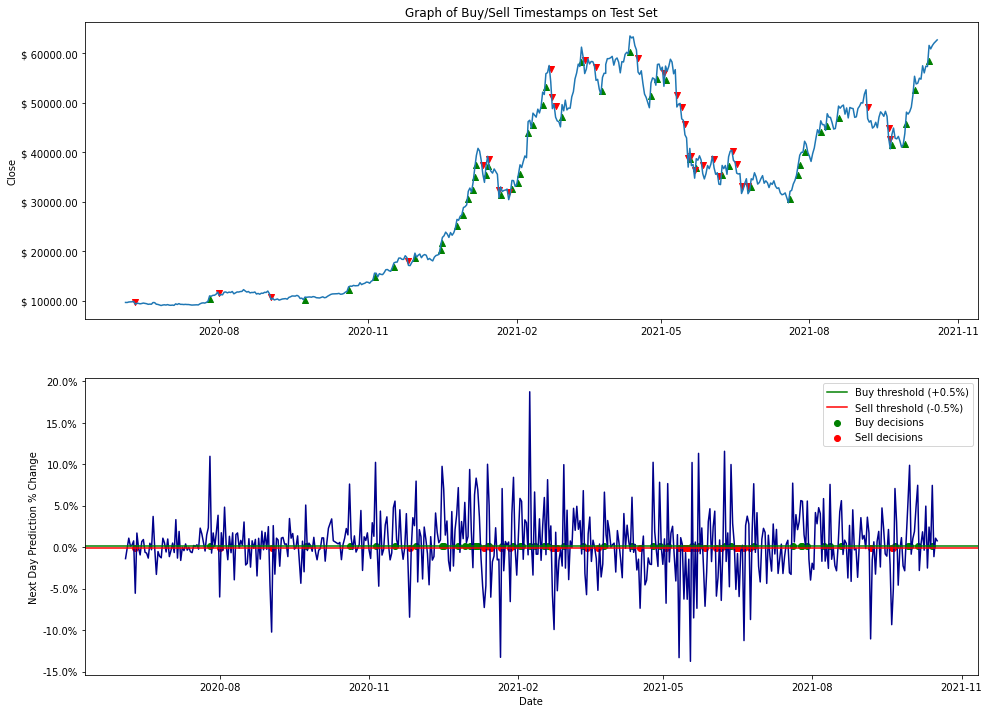

In [59]:
pred_data['Dates'] = pred_data.index
    
DATE_COLS = ['Dates']

ts_df = pred_data[['Dates','Predictions', 'Actual']]   
buy_sell_df = pred_data[['Dates','Buy','Sell']] 
buy_dates = buy_sell_df[buy_sell_df.Buy == 1].Dates
sell_dates = buy_sell_df[buy_sell_df.Sell == 1].Dates

buy_decisions = ts_df[ts_df.Dates.isin(buy_dates)]
sell_decisions = ts_df[ts_df.Dates.isin(sell_dates)]

ts_df['next_day_pct_change_pred'] = ts_df.Predictions.pct_change(periods=1).shift(-1) * 100
pct_change_df = ts_df.dropna()

months = mdates.MonthLocator(interval=3)

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)


## FIRST SUBPLOT

ax1.plot(ts_df.Dates, ts_df.Actual)
ax1.scatter(buy_decisions.Dates, buy_decisions.Actual * 0.95, color = 'green', marker = '^')
ax1.scatter(sell_decisions.Dates, sell_decisions.Actual * 1.05, color = 'red', marker = 'v')

# format title, x/y axis
dollar_formatter = ticker.FormatStrFormatter('$ %1.2f')
ax1.yaxis.set_major_formatter(dollar_formatter)
ax1.xaxis.set_major_locator(months)
ax1.set_ylabel('Close')
ax1.set_title('Graph of Buy/Sell Timestamps on Test Set')


## SECOND SUBPLOT

ax2.plot(pct_change_df.Dates, pct_change_df.next_day_pct_change_pred, color='darkblue')
ax2.axhline(y=0.15, color='green', label='Buy threshold (+0.5%)')
ax2.axhline(y=-0.15, color='red', label='Sell threshold (-0.5%)')
ax2.scatter(buy_decisions.Dates, [0.15] * len(buy_decisions), color='green', label='Buy decisions')
ax2.scatter(sell_decisions.Dates, [-0.15] * len(sell_decisions), color='red', label='Sell decisions')

# format title, x/y axis
ax2.legend()
ax2.yaxis.set_major_formatter(ticker.PercentFormatter())
ax2.xaxis.set_major_locator(months)
ax2.set_ylabel('Next Day Prediction % Change')
ax2.set_xlabel('Date')


## Output to png and plot in notebook

plt.savefig('buy-sell-decisions.png',bbox='tight')
plt.show()


# Model Comparisons

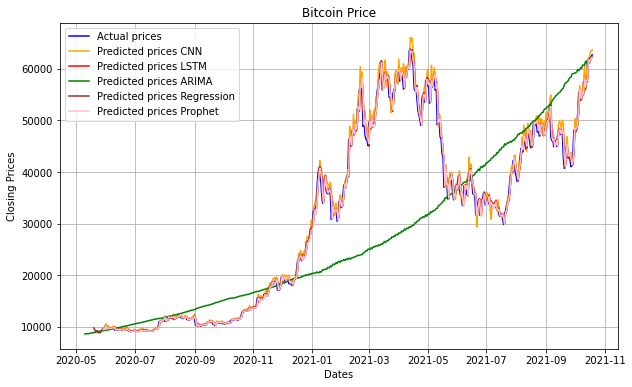

In [122]:
# Plot actual prices vs predicted prices 
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original,'b',label='Actual prices')
plt.plot(pred_data_CNN, 'orange',label='Predicted prices CNN')
plt.plot(pred_data_LSTM['Close'], 'red',label='Predicted prices LSTM')
plt.plot(predictions_ARIMA, 'Green',label='Predicted prices ARIMA')
plt.plot(pred_data_regr, 'Brown',label='Predicted prices Regression')
plt.plot(pred_data_prophet, 'Pink',label='Predicted prices Prophet')

pred_data_prophet
plt.title('Bitcoin Price')

plt.legend();